# Simple Moments Parameter Analysis

This notebook provides a straightforward analysis of moments optimization results, comparing ground truth parameters with estimated values.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
# Configuration - UPDATE THESE PATHS FOR YOUR EXPERIMENT
EXPERIMENT_NAME = 'bottleneck'  # Change this to your experiment
BASE_PATH = Path(f'/home/akapoor/kernlab/Infer_Demography/experiments/{EXPERIMENT_NAME}_1_10_perc')
SIMULATIONS_PATH = BASE_PATH / 'simulations'
RUNS_PATH = BASE_PATH / 'runs'

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Simulations path: {SIMULATIONS_PATH}")
print(f"Runs path: {RUNS_PATH}")
print(f"Paths exist: {SIMULATIONS_PATH.exists()}, {RUNS_PATH.exists()}")

Experiment: bottleneck
Simulations path: /home/akapoor/kernlab/Infer_Demography/experiments/bottleneck_1_10_perc/simulations
Runs path: /home/akapoor/kernlab/Infer_Demography/experiments/bottleneck_1_10_perc/runs
Paths exist: True, True


In [9]:
def load_ground_truth(simulations_path):
    """Load ground truth parameters from simulation directories."""
    gt_data = {}
    
    for sim_dir in sorted(simulations_path.glob('*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                gt_data[sim_id] = params
            except Exception as e:
                print(f"Error loading {param_file}: {e}")
    
    print(f"Loaded ground truth for {len(gt_data)} simulations")
    return gt_data

def load_coverage_data(simulations_path):
    """Load coverage percentage data from bgs.meta.json files."""
    coverage_data = {}
    
    for sim_dir in sorted(simulations_path.glob('*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name
        meta_file = sim_dir / 'bgs.meta.json'
        
        if meta_file.exists():
            try:
                with open(meta_file, 'r') as f:
                    meta = json.load(f)
                coverage_data[sim_id] = meta.get('sampled_coverage_percent', None)
            except Exception as e:
                print(f"Error loading {meta_file}: {e}")
                coverage_data[sim_id] = None
        else:
            coverage_data[sim_id] = None
    
    print(f"Loaded coverage data for {len(coverage_data)} simulations")
    valid_coverage = sum(1 for v in coverage_data.values() if v is not None)
    print(f"  {valid_coverage} simulations have coverage data")
    return coverage_data

def load_moments_results(runs_path):
    """Load moments optimization results."""
    results = {}
    
    for run_dir in sorted(runs_path.glob('run_*_*')):
        if not run_dir.is_dir():
            continue
            
        # Parse run directory name: run_sim_rep
        parts = run_dir.name.split('_')
        if len(parts) < 3:
            continue
            
        sim_id = parts[1]
        rep_id = parts[2]
        
        moments_dir = run_dir / 'inferences' / 'moments'
        if not moments_dir.exists():
            continue
            
        # Look for results file
        result_files = [
            moments_dir / 'best_fit.pkl',
            moments_dir / 'results.pkl',
            moments_dir / 'optimization_results.pkl'
        ]
        
        for result_file in result_files:
            if result_file.exists():
                try:
                    with open(result_file, 'rb') as f:
                        data = pickle.load(f)
                    
                    if sim_id not in results:
                        results[sim_id] = {}
                    results[sim_id][rep_id] = data
                    break  # Use first found file
                except Exception as e:
                    print(f"Error loading {result_file}: {e}")
    
    print(f"Loaded moments results for {len(results)} simulations")
    return results

def extract_parameters(moments_data):
    """Extract parameters and likelihood from moments results."""
    params = {}
    likelihood = None
    
    # Handle different result file formats
    if isinstance(moments_data, dict):
        # Look for parameters
        if 'best_params' in moments_data:
            if isinstance(moments_data['best_params'], dict):
                params = moments_data['best_params']
            elif 'param_order' in moments_data:
                order = moments_data['param_order']
                values = moments_data['best_params']
                params = dict(zip(order, values))
        
        # Look for likelihood
        for key in ['best_ll', 'log_likelihood', 'll']:
            if key in moments_data:
                val = moments_data[key]
                likelihood = val[0] if isinstance(val, (list, tuple)) else val
                break
    
    if likelihood is not None:
        params['log_likelihood'] = float(likelihood)
    
    return params

print("Helper functions defined!")

Helper functions defined!


In [10]:
# Load the data
print("Loading ground truth parameters...")
ground_truth = load_ground_truth(SIMULATIONS_PATH)

print("\nLoading coverage data...")
coverage_data = load_coverage_data(SIMULATIONS_PATH)

print("\nLoading moments results...")
moments_results = load_moments_results(RUNS_PATH)

# Show example data
if ground_truth:
    first_sim = list(ground_truth.keys())[0]
    print(f"\nExample ground truth parameters (sim {first_sim}):")
    for key, value in ground_truth[first_sim].items():
        print(f"  {key}: {value}")

if coverage_data:
    print(f"\nExample coverage data:")
    for i, (sim_id, coverage) in enumerate(list(coverage_data.items())[:5]):
        print(f"  Sim {sim_id}: {coverage}% coverage" if coverage else f"  Sim {sim_id}: No coverage data")

if moments_results:
    first_sim = list(moments_results.keys())[0]
    first_rep = list(moments_results[first_sim].keys())[0]
    example_params = extract_parameters(moments_results[first_sim][first_rep])
    print(f"\nExample estimated parameters (sim {first_sim}, rep {first_rep}):")
    for key, value in example_params.items():
        print(f"  {key}: {value}")

Loading ground truth parameters...
Loaded ground truth for 82 simulations

Loading coverage data...
Loaded coverage data for 85 simulations
  82 simulations have coverage data

Loading moments results...
Loaded moments results for 82 simulations

Example ground truth parameters (sim 0):
  N0: 16094.20619795231
  N_bottleneck: 827.0660448476755
  N_recover: 19924.051576565053
  t_bottleneck_start: 2838.7148288445132
  t_bottleneck_end: 670.8602784544544

Example coverage data:
  Sim 0: 2.597169241918491% coverage
  Sim 1: 4.277428977944211% coverage
  Sim 10: 1.4173944177534947% coverage
  Sim 11: 6.303302296591685% coverage
  Sim 12: 5.5147184945145415% coverage

Example estimated parameters (sim 0, rep 0):
  N0: 16094.20619795231
  N_bottleneck: 827.0660448476755
  N_recover: 20000.000000000004
  t_bottleneck_start: 3000.0000000000014
  t_bottleneck_end: 508.4019268695684
  log_likelihood: 634276.5040572914


In [11]:
# Create comparison dataframe
comparison_data = []

for sim_id in ground_truth.keys():
    if sim_id not in moments_results:
        continue
        
    gt_params = ground_truth[sim_id]
    coverage = coverage_data.get(sim_id, None)  # Get coverage for this simulation
    
    for rep_id, rep_data in moments_results[sim_id].items():
        est_params = extract_parameters(rep_data)
        
        # Find common parameters
        common_params = set(gt_params.keys()) & set(est_params.keys())
        common_params.discard('log_likelihood')  # Don't compare likelihood
        
        for param in common_params:
            gt_val = gt_params[param]
            est_val = est_params[param]
            
            comparison_data.append({
                'simulation': sim_id,
                'replicate': rep_id,
                'parameter': param,
                'ground_truth': gt_val,
                'estimated': est_val,
                'absolute_error': est_val - gt_val,
                'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan,
                'coverage_percent': coverage
            })
        
        # Add likelihood separately
        if 'log_likelihood' in est_params:
            comparison_data.append({
                'simulation': sim_id,
                'replicate': rep_id,
                'parameter': 'log_likelihood',
                'ground_truth': np.nan,
                'estimated': est_params['log_likelihood'],
                'absolute_error': np.nan,
                'relative_error': np.nan,
                'coverage_percent': coverage
            })

df = pd.DataFrame(comparison_data)
print(f"Created comparison dataframe with {len(df)} rows")
print(f"Parameters: {sorted(df['parameter'].unique())}")
print(f"Simulations: {len(df['simulation'].unique())}")

# Check coverage data distribution
coverage_stats = df['coverage_percent'].describe()
print(f"\nCoverage percentage statistics:")
print(coverage_stats)

# Show first few rows
display(df.head(10))

Created comparison dataframe with 492 rows
Parameters: ['N0', 'N_bottleneck', 'N_recover', 'log_likelihood', 't_bottleneck_end', 't_bottleneck_start']
Simulations: 82

Coverage percentage statistics:
count    492.000000
mean       4.898583
std        2.465998
min        1.051262
25%        2.589373
50%        4.889548
75%        6.889843
max        9.973719
Name: coverage_percent, dtype: float64


,simulation,replicate,parameter,ground_truth,estimated,absolute_error,relative_error,coverage_percent
0,0,0,t_bottleneck_end,670.860278,508.401927,-162.458352,-0.242164,2.597169
1,0,0,N_bottleneck,827.066045,827.066045,0.000000,0.000000,2.597169
2,0,0,N_recover,19924.051577,20000.000000,75.948423,0.003812,2.597169
3,0,0,N0,16094.206198,16094.206198,0.000000,0.000000,2.597169
4,0,0,t_bottleneck_start,2838.714829,3000.000000,161.285171,0.056816,2.597169
5,0,0,log_likelihood,NaN,634276.504057,NaN,NaN,2.597169
6,1,0,t_bottleneck_end,536.895771,516.603543,-20.292228,-0.037795,4.277429
7,1,0,N_bottleneck,868.276094,868.276094,0.000000,0.000000,4.277429
8,1,0,N_recover,17745.770638,17788.229975,42.459338,0.002393,4.277429
9,1,0,N0,12942.048256,12942.048256,0.000000,0.000000,4.277429


Plotting 5 parameters: ['t_bottleneck_end', 'N_bottleneck', 'N_recover', 'N0', 't_bottleneck_start']


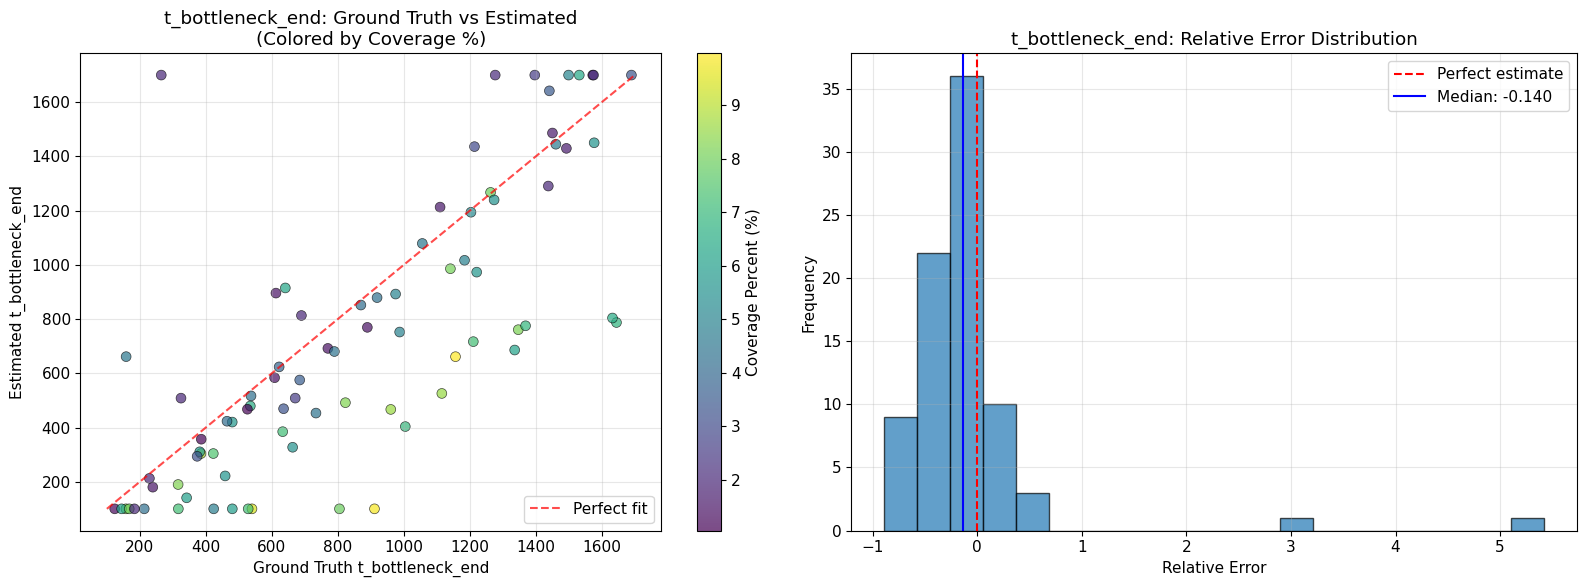


t_bottleneck_end Statistics:
  Estimates: 82
  Correlation: 0.7842
  RMSE: 343.5093
  Mean relative error: -0.1007
  Std relative error: 0.7833
  Coverage range: 1.1% - 10.0%
  Mean coverage: 4.9%




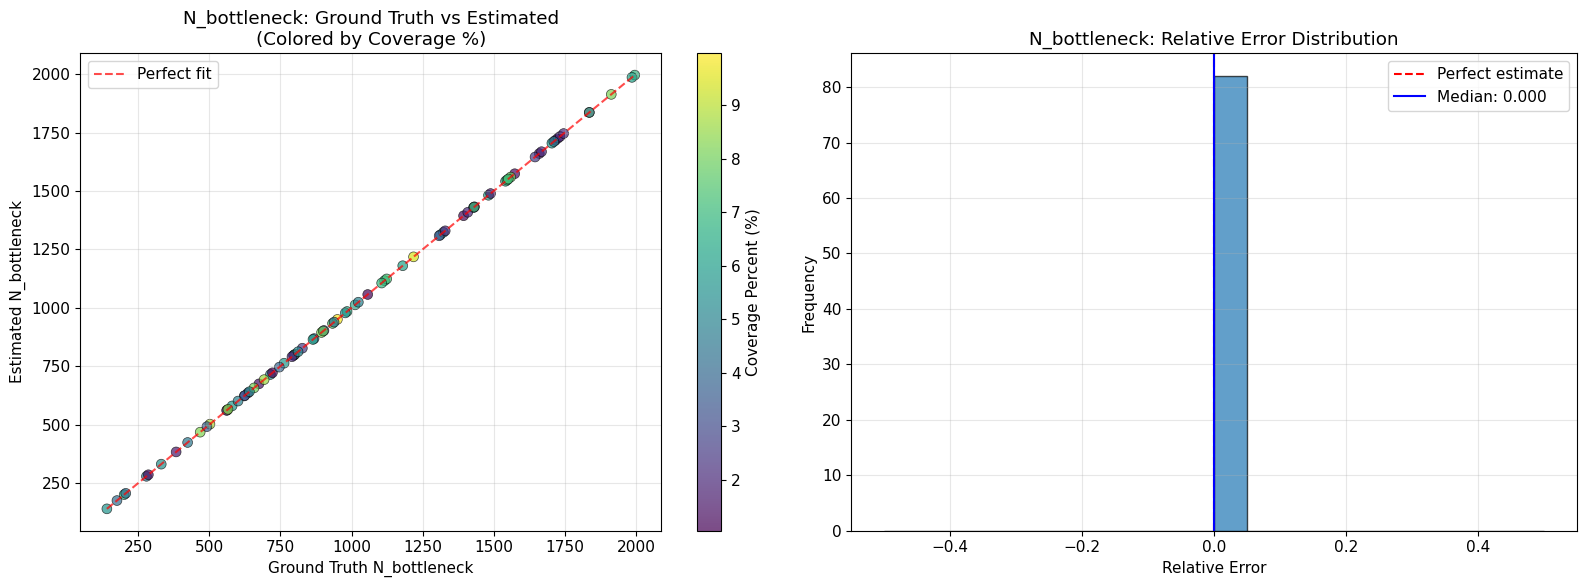


N_bottleneck Statistics:
  Estimates: 82
  Correlation: 1.0000
  RMSE: 0.0000
  Mean relative error: 0.0000
  Std relative error: 0.0000
  Coverage range: 1.1% - 10.0%
  Mean coverage: 4.9%




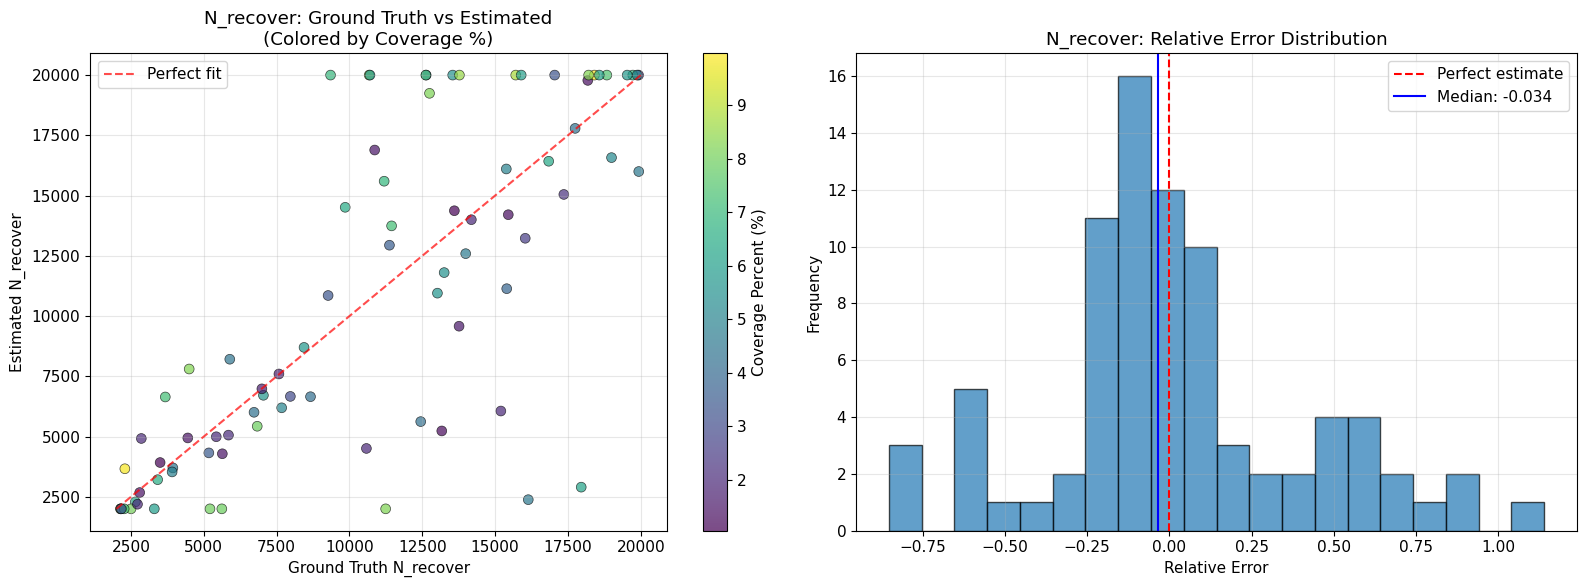


N_recover Statistics:
  Estimates: 82
  Correlation: 0.7738
  RMSE: 4342.5886
  Mean relative error: 0.0162
  Std relative error: 0.3940
  Coverage range: 1.1% - 10.0%
  Mean coverage: 4.9%




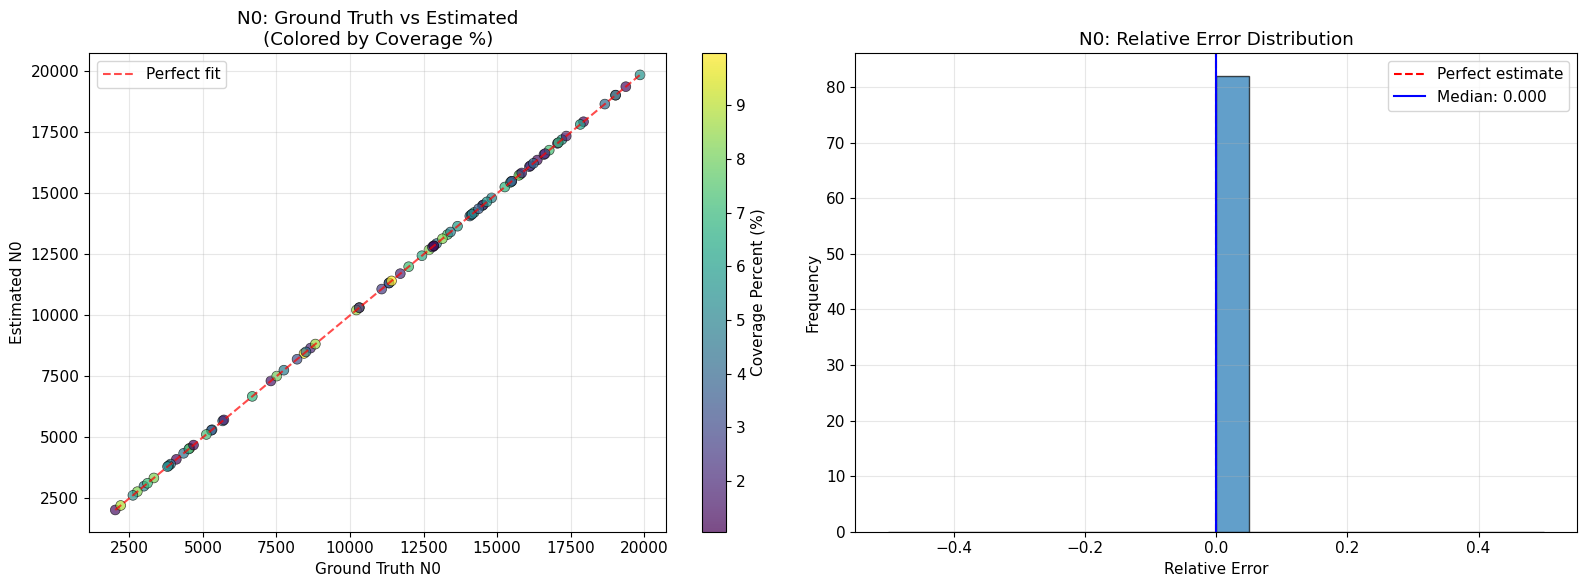


N0 Statistics:
  Estimates: 82
  Correlation: 1.0000
  RMSE: 0.0000
  Mean relative error: 0.0000
  Std relative error: 0.0000
  Coverage range: 1.1% - 10.0%
  Mean coverage: 4.9%




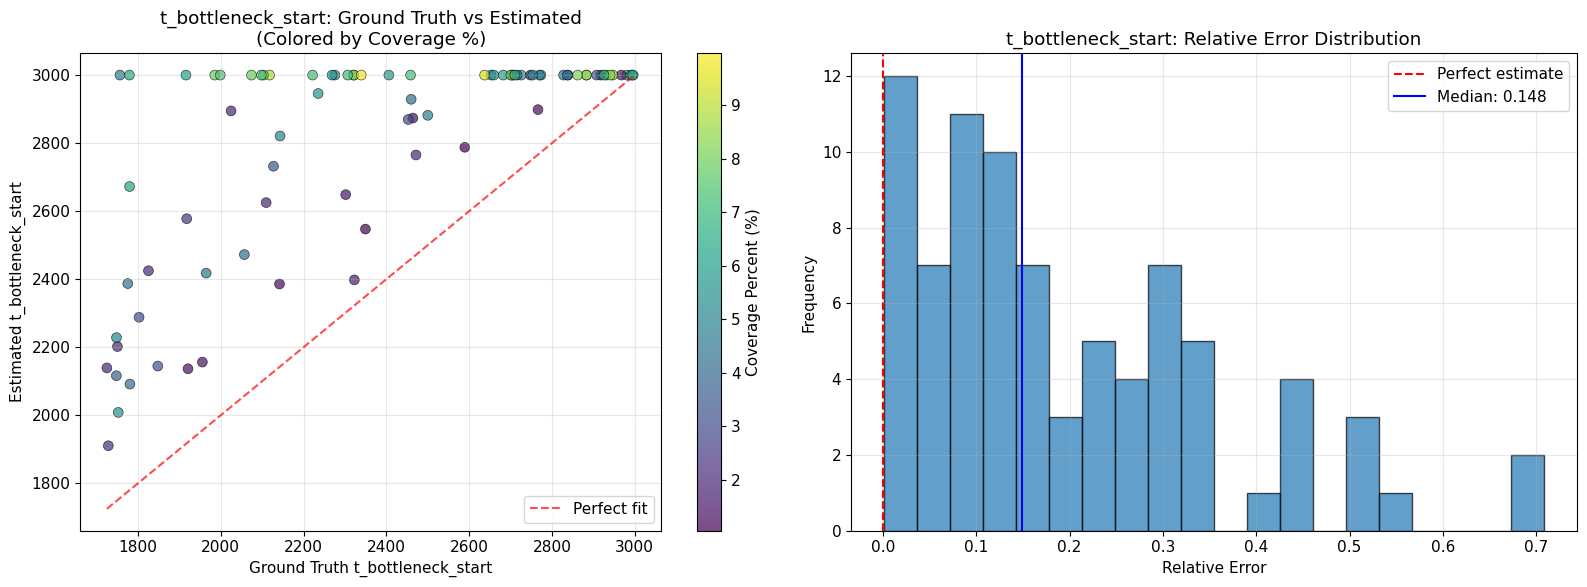


t_bottleneck_start Statistics:
  Estimates: 82
  Correlation: 0.6852
  RMSE: 519.5697
  Mean relative error: 0.1976
  Std relative error: 0.1624
  Coverage range: 1.1% - 10.0%
  Mean coverage: 4.9%


Cross-Parameter Analysis:
Not enough migration parameters found for cross-parameter analysis


In [12]:
# Plot parameter comparisons
def plot_parameter(df, param_name):
    """Plot ground truth vs estimated for a parameter, colored by coverage percentage."""
    param_data = df[df['parameter'] == param_name]
    
    if len(param_data) == 0:
        print(f"No data for parameter {param_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot colored by coverage
    coverage = param_data['coverage_percent']
    
    # Handle case where some coverage data might be missing
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = ax1.scatter(param_data[valid_coverage]['ground_truth'], 
                            param_data[valid_coverage]['estimated'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(param_data):
            ax1.scatter(param_data[~valid_coverage]['ground_truth'], 
                       param_data[~valid_coverage]['estimated'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        ax1.scatter(param_data['ground_truth'], param_data['estimated'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect fit')
    
    ax1.set_xlabel(f'Ground Truth {param_name}')
    ax1.set_ylabel(f'Estimated {param_name}')
    ax1.set_title(f'{param_name}: Ground Truth vs Estimated\n(Colored by Coverage %)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Error histogram
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
    
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{param_name}: Relative Error Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    valid_data = param_data.dropna(subset=['ground_truth', 'estimated'])
    if len(valid_data) > 0:
        corr = valid_data['ground_truth'].corr(valid_data['estimated'])
        rmse = np.sqrt((valid_data['absolute_error']**2).mean())
        print(f"\n{param_name} Statistics:")
        print(f"  Estimates: {len(valid_data)}")
        print(f"  Correlation: {corr:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        if len(valid_errors) > 0:
            print(f"  Mean relative error: {valid_errors.mean():.4f}")
            print(f"  Std relative error: {valid_errors.std():.4f}")
        
        # Coverage-related statistics
        coverage_valid = valid_data['coverage_percent'].notna()
        if coverage_valid.sum() > 0:
            print(f"  Coverage range: {valid_data['coverage_percent'].min():.1f}% - {valid_data['coverage_percent'].max():.1f}%")
            print(f"  Mean coverage: {valid_data['coverage_percent'].mean():.1f}%")

def plot_cross_parameter(df, param1_est, param2_gt, title_suffix=""):
    """Plot estimated param1 vs ground truth param2 to check for parameter confusion, colored by coverage."""
    # Get data for both parameters
    param1_data = df[df['parameter'] == param1_est][['simulation', 'replicate', 'estimated', 'coverage_percent']].rename(columns={'estimated': f'{param1_est}_estimated'})
    param2_data = df[df['parameter'] == param2_gt][['simulation', 'replicate', 'ground_truth']].rename(columns={'ground_truth': f'{param2_gt}_ground_truth'})
    
    # Merge data
    merged_data = pd.merge(param1_data, param2_data, on=['simulation', 'replicate'], how='inner')
    
    if len(merged_data) == 0:
        print(f"No overlapping data for {param1_est} estimated vs {param2_gt} ground truth")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Scatter plot colored by coverage
    coverage = merged_data['coverage_percent']
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = plt.scatter(merged_data[valid_coverage][f'{param2_gt}_ground_truth'], 
                            merged_data[valid_coverage][f'{param1_est}_estimated'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(merged_data):
            plt.scatter(merged_data[~valid_coverage][f'{param2_gt}_ground_truth'], 
                       merged_data[~valid_coverage][f'{param1_est}_estimated'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        plt.scatter(merged_data[f'{param2_gt}_ground_truth'], merged_data[f'{param1_est}_estimated'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    plt.xlabel(f'Ground Truth {param2_gt}')
    plt.ylabel(f'Estimated {param1_est}')
    plt.title(f'Cross-Parameter Analysis: {param1_est} Estimated vs {param2_gt} Ground Truth{title_suffix}\n(Colored by Coverage %)')
    plt.grid(True, alpha=0.3)
    
    # Calculate correlation
    corr = merged_data[f'{param2_gt}_ground_truth'].corr(merged_data[f'{param1_est}_estimated'])
    plt.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Cross-parameter correlation ({param1_est} est vs {param2_gt} gt): {corr:.4f}")
    print(f"Data points: {len(merged_data)}")
    
    return corr

# Plot each parameter
parameters = [p for p in df['parameter'].unique() if p != 'log_likelihood']
print(f"Plotting {len(parameters)} parameters: {parameters}")

for param in parameters:
    plot_parameter(df, param)
    print("\n" + "="*60 + "\n")

# Cross-parameter analysis
print("Cross-Parameter Analysis:")
print("="*50)

# Check for parameter confusion between migration rates
available_params = df['parameter'].unique()
migration_params = [p for p in available_params if 'm' in p.lower() and p != 'log_likelihood']

if len(migration_params) >= 2:
    print(f"Found migration parameters: {migration_params}")
    
    # Plot m12 estimated vs m21 ground truth (and vice versa)
    for i, param1 in enumerate(migration_params):
        for j, param2 in enumerate(migration_params):
            if i != j:  # Don't compare parameter with itself
                print(f"\nAnalyzing: {param1} estimated vs {param2} ground truth")
                corr = plot_cross_parameter(df, param1, param2)
                print("-" * 40)
else:
    print("Not enough migration parameters found for cross-parameter analysis")
    
# You can also check other parameter pairs
other_cross_checks = [
    # Add any other parameter pairs you want to check, e.g.:
    # ('N_YRI', 'N_CEU'),
    # ('T_split', 'N_anc'),
]

for param1, param2 in other_cross_checks:
    if param1 in available_params and param2 in available_params:
        print(f"\nAnalyzing: {param1} estimated vs {param2} ground truth")
        plot_cross_parameter(df, param1, param2)
        print("-" * 40)

Best Estimates Summary (Highest Likelihood per Simulation):

N_YRI:
  Count: 100
  Mean relative error: -0.0018
  Std relative error: 0.0800
  Within 5%: 66/100 (66.0%)
  Within 10%: 88/100 (88.0%)

T_split:
  Count: 100
  Mean relative error: -0.0195
  Std relative error: 0.2031
  Within 5%: 37/100 (37.0%)
  Within 10%: 54/100 (54.0%)

m21:
  Count: 100
  Mean relative error: -0.1008
  Std relative error: 0.4586
  Within 5%: 9/100 (9.0%)
  Within 10%: 26/100 (26.0%)

N_CEU:
  Count: 100
  Mean relative error: 0.0143
  Std relative error: 0.1284
  Within 5%: 58/100 (58.0%)
  Within 10%: 88/100 (88.0%)

N_anc:
  Count: 100
  Mean relative error: 0.0005
  Std relative error: 0.0340
  Within 5%: 92/100 (92.0%)
  Within 10%: 97/100 (97.0%)

m12:
  Count: 100
  Mean relative error: 0.0236
  Std relative error: 0.5427
  Within 5%: 19/100 (19.0%)
  Within 10%: 31/100 (31.0%)


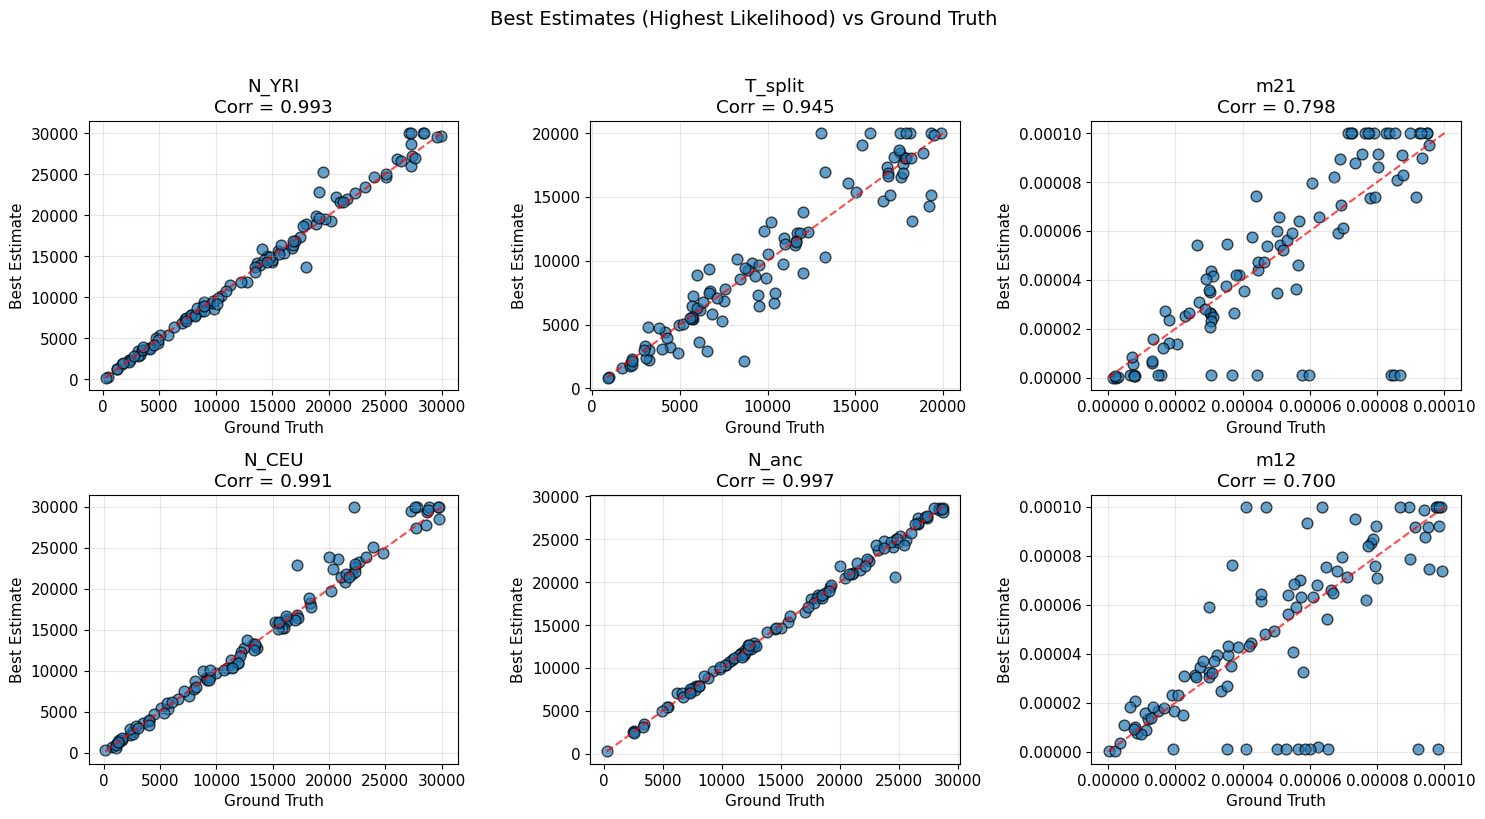

In [68]:
# Best estimates analysis (highest likelihood per simulation)
ll_data = df[df['parameter'] == 'log_likelihood']

if not ll_data.empty:
    best_estimates = []
    
    for sim_id in ll_data['simulation'].unique():
        sim_ll = ll_data[ll_data['simulation'] == sim_id]
        best_rep = sim_ll.loc[sim_ll['estimated'].idxmax(), 'replicate']
        
        # Get all parameters for this simulation's best replicate
        best_data = df[(df['simulation'] == sim_id) & 
                      (df['replicate'] == best_rep) & 
                      (df['parameter'] != 'log_likelihood')]
        
        for _, row in best_data.iterrows():
            best_estimates.append({
                'simulation': row['simulation'],
                'parameter': row['parameter'],
                'ground_truth': row['ground_truth'],
                'best_estimate': row['estimated'],
                'relative_error': row['relative_error']
            })
    
    best_df = pd.DataFrame(best_estimates)
    
    if not best_df.empty:
        print("Best Estimates Summary (Highest Likelihood per Simulation):")
        print("=" * 60)
        
        for param in best_df['parameter'].unique():
            param_data = best_df[best_df['parameter'] == param]
            
            print(f"\n{param}:")
            print(f"  Count: {len(param_data)}")
            print(f"  Mean relative error: {param_data['relative_error'].mean():.4f}")
            print(f"  Std relative error: {param_data['relative_error'].std():.4f}")
            
            # Accuracy within thresholds
            within_5pct = (np.abs(param_data['relative_error']) <= 0.05).sum()
            within_10pct = (np.abs(param_data['relative_error']) <= 0.10).sum()
            total = len(param_data)
            print(f"  Within 5%: {within_5pct}/{total} ({100*within_5pct/total:.1f}%)")
            print(f"  Within 10%: {within_10pct}/{total} ({100*within_10pct/total:.1f}%)")
        
        # Plot best estimates
        params = best_df['parameter'].unique()
        n_params = len(params)
        
        if n_params > 0:
            cols = min(3, n_params)
            rows = (n_params + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
            if n_params == 1:
                axes = [axes]
            elif rows == 1:
                axes = [axes] if cols == 1 else axes
            else:
                axes = axes.flatten()
            
            for i, param in enumerate(params):
                ax = axes[i]
                param_data = best_df[best_df['parameter'] == param]
                
                ax.scatter(param_data['ground_truth'], param_data['best_estimate'], 
                          alpha=0.7, s=60, edgecolors='black')
                
                # Identity line
                min_val = min(param_data['ground_truth'].min(), param_data['best_estimate'].min())
                max_val = max(param_data['ground_truth'].max(), param_data['best_estimate'].max())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
                
                # Correlation
                corr = param_data['ground_truth'].corr(param_data['best_estimate'])
                ax.set_title(f'{param}\nCorr = {corr:.3f}')
                ax.set_xlabel('Ground Truth')
                ax.set_ylabel('Best Estimate')
                ax.grid(True, alpha=0.3)
            
            # Hide unused subplots
            for i in range(n_params, len(axes)):
                axes[i].set_visible(False)
            
            plt.suptitle('Best Estimates (Highest Likelihood) vs Ground Truth', 
                        fontsize=14, y=1.02)
            plt.tight_layout()
            plt.show()
    
else:
    print("No likelihood data found - cannot identify best estimates")

In [69]:
# Summary statistics by parameter
print("Overall Parameter Statistics:")
print("=" * 50)

for param in [p for p in df['parameter'].unique() if p != 'log_likelihood']:
    param_data = df[df['parameter'] == param]
    
    print(f"\n{param}:")
    print(f"  Total estimates: {len(param_data)}")
    print(f"  Simulations: {len(param_data['simulation'].unique())}")
    
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        print(f"  Mean relative error: {valid_errors.mean():.4f}")
        print(f"  Median relative error: {valid_errors.median():.4f}")
        print(f"  Std relative error: {valid_errors.std():.4f}")
        
        # Percentiles
        p25, p75 = np.percentile(np.abs(valid_errors), [25, 75])
        print(f"  25th percentile |error|: {p25:.4f}")
        print(f"  75th percentile |error|: {p75:.4f}")

print("\n" + "="*50)
print("Analysis complete!")

Overall Parameter Statistics:

N_YRI:
  Total estimates: 100
  Simulations: 100
  Mean relative error: -0.0018
  Median relative error: 0.0054
  Std relative error: 0.0800
  25th percentile |error|: 0.0153
  75th percentile |error|: 0.0653

T_split:
  Total estimates: 100
  Simulations: 100
  Mean relative error: -0.0195
  Median relative error: -0.0029
  Std relative error: 0.2031
  25th percentile |error|: 0.0302
  75th percentile |error|: 0.2347

m21:
  Total estimates: 100
  Simulations: 100
  Mean relative error: -0.1008
  Median relative error: 0.0445
  Std relative error: 0.4586
  25th percentile |error|: 0.0983
  75th percentile |error|: 0.4078

N_CEU:
  Total estimates: 100
  Simulations: 100
  Mean relative error: 0.0143
  Median relative error: -0.0018
  Std relative error: 0.1284
  25th percentile |error|: 0.0192
  75th percentile |error|: 0.0782

N_anc:
  Total estimates: 100
  Simulations: 100
  Mean relative error: 0.0005
  Median relative error: 0.0021
  Std relative er